# ベイズ階層線形回帰
http://num.pyro.ai/en/latest/tutorials/bayesian_hierarchical_linear_regression.html

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('https://gist.githubusercontent.com/ucals/'
                    '2cf9d101992cb1b78c2cdd6e3bac6a4b/raw/'
                    '43034c39052dcf97d4b894d2ec1bc3f90f3623d9/'
                    'osic_pulmonary_fibrosis.csv')
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


データセットは、一連の患者のベースライン胸部CTスキャンと関連する臨床情報

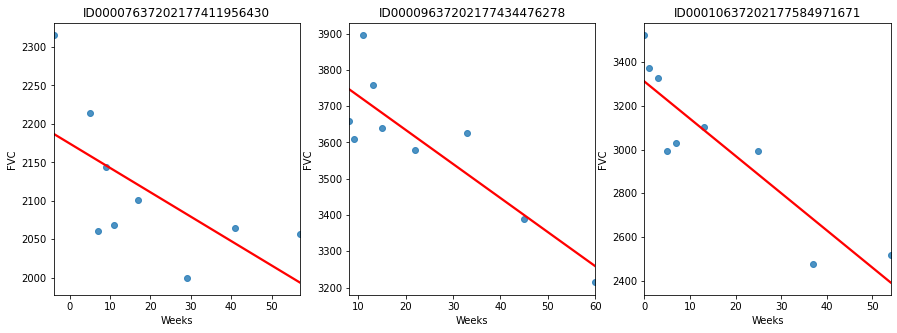

In [3]:
def chart(patient_id, ax):
    data = train[train['Patient'] == patient_id]
    x = data['Weeks']
    y = data['FVC']
    ax.set_title(patient_id)
    ax = sns.regplot(x, y, ax=ax, ci=None, line_kws={'color':'red'})


f, axes = plt.subplots(1, 3, figsize=(15, 5))
chart('ID00007637202177411956430', axes[0])
chart('ID00009637202177434476278', axes[1])
chart('ID00010637202177584971671', axes[2])

#### model

In [4]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random

assert numpyro.__version__.startswith('0.6.0')

In [5]:
# GPUだとMCMC遅いのでcpu使う
numpyro.set_platform("cpu")

In [6]:
def model(PatientID, Weeks, FVC_obs=None):
    μ_α = numpyro.sample("μ_α", dist.Normal(0., 100.))
    σ_α = numpyro.sample("σ_α", dist.HalfNormal(100.))
    μ_β = numpyro.sample("μ_β", dist.Normal(0., 100.))
    σ_β = numpyro.sample("σ_β", dist.HalfNormal(100.))

    unique_patient_IDs = np.unique(PatientID)
    n_patients = len(unique_patient_IDs)

    with numpyro.plate("plate_i", n_patients):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        β = numpyro.sample("β", dist.Normal(μ_β, σ_β))

    σ = numpyro.sample("σ", dist.HalfNormal(100.))
    FVC_est = α[PatientID] + β[PatientID] * Weeks

    with numpyro.plate("data", len(PatientID)):
        numpyro.sample("obs", dist.Normal(FVC_est, σ), obs=FVC_obs)

#### MCMC

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['PatientID'] = le.fit_transform(train['Patient'].values)

FVC_obs = train['FVC'].values
Weeks = train['Weeks'].values
PatientID = train['PatientID'].values

In [8]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, PatientID, Weeks, FVC_obs=FVC_obs)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████████████████████████████████| 4000/4000 [00:50<00:00, 78.92it/s, 127 steps of size 1.19e-02. acc. prob=0.92]


#### param check

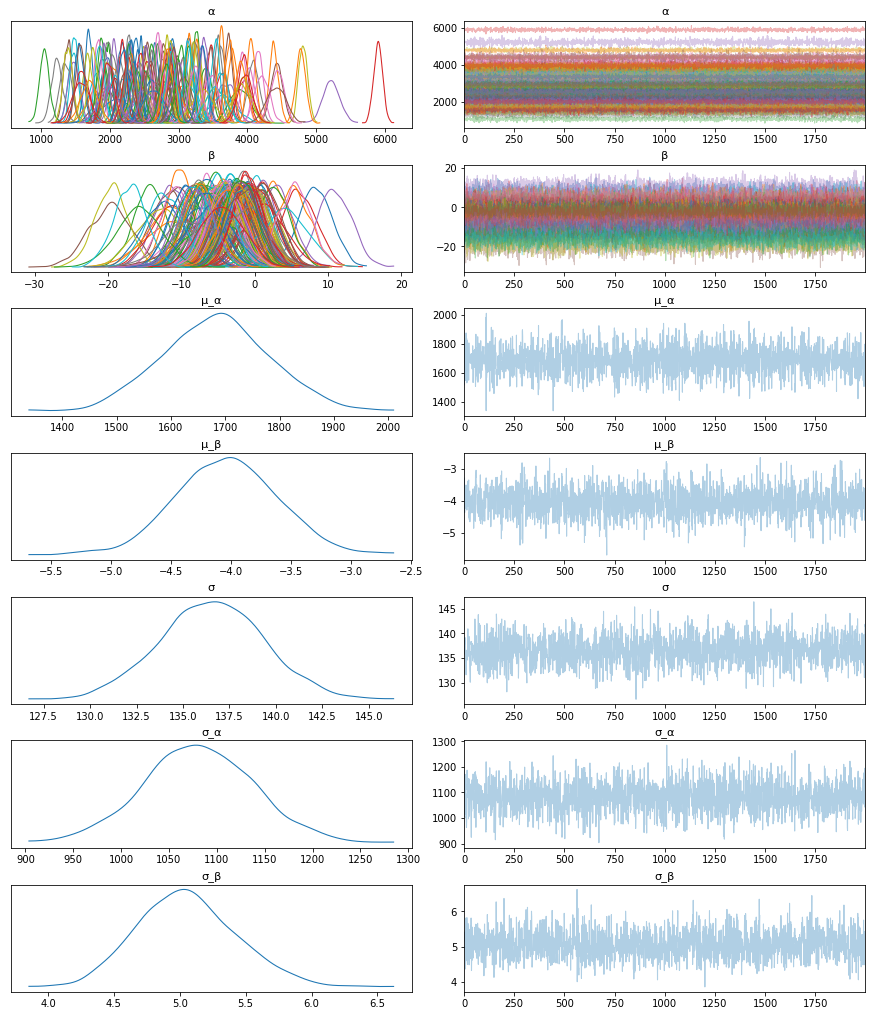

In [9]:
import arviz as az

data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

患者ごとにパーソナライズされたアルファとベータを学習できた

#### モデルによって予測されたFVC低下曲線を可視化

データセットの欠落しているすべての値を予測する

In [10]:
pred_template = []
for i in range(train['Patient'].nunique()):
    df = pd.DataFrame(columns=['PatientID', 'Weeks'])
    df['Weeks'] = np.arange(-12, 134)
    df['PatientID'] = i
    pred_template.append(df)
pred_template = pd.concat(pred_template, ignore_index=True)

In [11]:
PatientID = pred_template['PatientID'].values
Weeks = pred_template['Weeks'].values
predictive = Predictive(model, posterior_samples,
                        return_sites=['σ', 'obs'])
samples_predictive = predictive(random.PRNGKey(0),
                                PatientID, Weeks, None)

In [12]:
df = pd.DataFrame(columns=['Patient', 'Weeks', 'FVC_pred', 'sigma'])
df['Patient'] = le.inverse_transform(pred_template['PatientID'])
df['Weeks'] = pred_template['Weeks']
df['FVC_pred'] = samples_predictive['obs'].T.mean(axis=1)
df['sigma'] = samples_predictive['obs'].T.std(axis=1)
df['FVC_inf'] = df['FVC_pred'] - df['sigma']
df['FVC_sup'] = df['FVC_pred'] + df['sigma']
df = pd.merge(df, train[['Patient', 'Weeks', 'FVC']],
              how='left', on=['Patient', 'Weeks'])
df = df.rename(columns={'FVC': 'FVC_true'})
df.head()

,Patient,Weeks,FVC_pred,sigma,FVC_inf,FVC_sup,FVC_true
0,ID00007637202177411956430,-12,2218.251953,159.864990,2058.386963,2378.116943,NaN
1,ID00007637202177411956430,-11,2208.076904,160.750916,2047.325928,2368.827881,NaN
2,ID00007637202177411956430,-10,2211.191406,153.965607,2057.225830,2365.156982,NaN
3,ID00007637202177411956430,-9,2206.881592,153.928360,2052.953125,2360.810059,NaN
4,ID00007637202177411956430,-8,2201.002930,157.634186,2043.368774,2358.637207,NaN


3人の患者の予測だけ確認

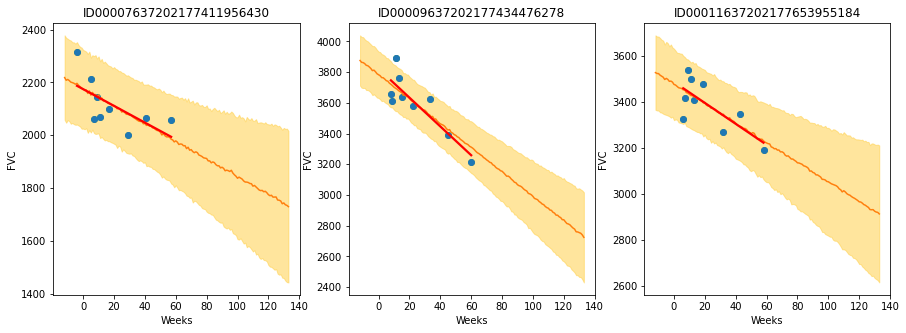

In [13]:
def chart(patient_id, ax):
    data = df[df['Patient'] == patient_id]
    x = data['Weeks']
    ax.set_title(patient_id)
    ax.plot(x, data['FVC_true'], 'o')
    ax.plot(x, data['FVC_pred'])
    ax = sns.regplot(x, data['FVC_true'], ax=ax, ci=None,
                     line_kws={'color':'red'})
    ax.fill_between(x, data["FVC_inf"], data["FVC_sup"],
                    alpha=0.5, color='#ffcd3c')
    ax.set_ylabel('FVC')

f, axes = plt.subplots(1, 3, figsize=(15, 5))
chart('ID00007637202177411956430', axes[0])
chart('ID00009637202177434476278', axes[1])
chart('ID00011637202177653955184', axes[2])

#### モデルの予測の精度評価
RMSEと対数尤度を計算

In [14]:
y = df.dropna()
rmse = ((y['FVC_pred'] - y['FVC_true']) ** 2).mean() ** (1/2)
print(f'RMSE: {rmse:.1f} ml')

sigma_c = y['sigma'].values
sigma_c[sigma_c < 70] = 70
delta = (y['FVC_pred'] - y['FVC_true']).abs()
delta[delta > 1000] = 1000
lll = - np.sqrt(2) * delta / sigma_c - np.log(np.sqrt(2) * sigma_c)
print(f'Laplace Log Likelihood: {lll.mean():.4f}')

RMSE: 122.1 ml
Laplace Log Likelihood: -6.1381
